# Analytic magnetic field created by a ZS configuration in Halbach configuration

For creating an analytic magnetic field created by a ZS configuration in Halbach configuration, we must consider the magnetic field created by a $2a \times 2b \times 2c$ cuboid magnetized, $\textbf{M}$ along the $y$ axis.
For calculating this we can use the analytical expression of a rectangular coil, considering the magnet is equivalent to a stack of rectangular coils with magnetic field $\textbf{B}_{coil} = \mu_0 I \textbf{b}$ with current $I$.

Therefore, the magnetic field created by a cuboid at a point $(x,y,z)$ is given by the integration of the contributions of each rectangular coil that forms the cuboid integrated in the z-axis giving the expression:
$$\textbf{B}_{sol} (x,y,z) = \mu_0 J_s \sum^1_{n,p,q=0} (-1)^{n+p+q} \mathcal{B} (x-(-1)^p a , y -(-1)^n b , z - (-1)^q c)$$
where
$$\mathcal{B}_x (X,Y,Z) = \frac{1}{2} \log{\frac{\sqrt{X^2 + y^2 + Z^2}-Z}{\sqrt{X^2 + y^2 + Z^2}+Z}}$$
$$\mathcal{B}_y (X,Y,Z) = - \arctan \frac{Y\sqrt{X^2 + Y^2 + Z^2}}{XZ}$$
$$\mathcal{B}_z (X,Y,Z) = \mathcal{B}_x (Z,Y,X)$$
and $J_s = M$ is the equivalent surface current density of the magnet which for hard magnetic materials can be taken equal to $B_R$ **(divided by 4pi?)**.

This is the magnetic field created by a single cuboid magnetized along the y-axis in the magnet frame.

To calculate the total magnetic field created by the ZS configuration in Halbach configuration we must sum the contributions of each magnet considering their position and orientation.

Hence, each magnet $i$ located at position $\textbf{r}_i$ with angle $\beta_i$ and $z_0$, using cylindrical coordinates, undergoes a translation,
$$x \rightarrow{} x_p = x - r_i \sin{\beta},$$
$$y \rightarrow{} y_p = y - r_i \cos{\beta}$$
$$z \rightarrow{} z_p = z - z_0$$
a rotation around the z-axis of an angle $2\beta_i$, therefore in the xy plane,
$$\begin{pmatrix}
x_r \\
y_r \\
z_r
\end{pmatrix} =
\begin{pmatrix}
\cos{2\beta_i} & -\sin{2\beta_i} & 0 \\
\sin{2\beta_i} & \cos{2\beta_i} & 0 \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
x_p \\
y_p \\
z_p
\end{pmatrix},
\\$$
and another rotation of angle $\alpha$ around $v = \cos{\beta} x_r + \sin{\beta} y_r = (\cos{\beta}, \sin{\beta}, 0)$,
$$\begin{pmatrix}
x_t \\
y_t \\
z_t
\end{pmatrix} =
\begin{pmatrix}
(\cos{\beta_i})^2 (1-\cos{\alpha}) + cos{\alpha} & \cos{\beta_i}\sin{\beta_i} (1-\cos{\alpha}) & \sin{\beta_i} \sin{\alpha} \\
\cos{\beta_i}\sin{\beta_i} (1-\cos{\alpha}) & (\sin{\beta_i})^2 (1-\cos{\alpha}) + cos{\alpha} & \cos{\beta_i} \sin{\alpha} \\
-\sin{\beta_i} \sin{\alpha} & \cos{\beta_i} \sin{\alpha} & \cos{\alpha}
\end{pmatrix}
\begin{pmatrix}
x_t \\
y_t \\
z_t
\end{pmatrix},
\\$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


# Angles for the 8 segments of the Halbach array
BETAS = np.linspace(0, 2 * np.pi, 8, endpoint=False)  # n * pi/4 for n=0..7
EPS = 1e-12  # Small value to prevent division by zero


def _broadcast(*arrays):
    """Broadcast input arrays to a common shape with float dtype."""
    return np.broadcast_arrays(*[np.asarray(arr, dtype=float) for arr in arrays])


def translate_to_ring_frame(x, y, z, r0, z0, beta):
    """Translate lab-frame coordinates to the displaced magnet frame."""
    x, y, z, r0, z0 = _broadcast(x, y, z, r0, z0)
    xp = x - r0 * np.sin(beta)
    yp = y - r0 * np.cos(beta)
    zp = z - z0
    return xp, yp, zp


def rotate_xy_plane(x, y, angle):
    """Rotate coordinates in the XY plane by the provided angle."""
    x, y, angle = _broadcast(x, y, angle)
    c = np.cos(angle)
    s = np.sin(angle)
    xr = c * x - s * y
    yr = s * x + c * y
    return xr, yr


def rotate_about_v(xs, ys, zs, alpha, beta):
    """Rotate coordinates about the Halbach axis defined by beta."""
    xs, ys, zs, alpha = _broadcast(xs, ys, zs, alpha)
    cb = np.cos(beta)
    sb = np.sin(beta)
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    xt = (cb**2 * (1 - ca) + ca) * xs + cb * sb * (1 - ca) * ys + sb * sa * zs
    yt = cb * sb * (1 - ca) * xs + (sb**2 * (1 - ca) + ca) * ys - cb * sa * zs
    zt = -sb * sa * xs + cb * sa * ys + ca * zs
    return xt, yt, zt


def inverse_rotate_about_v(bxt, byt, bzt, alpha, beta):
    """Undo the rotation about the Halbach axis for vector components."""
    bxt, byt, bzt, alpha = _broadcast(bxt, byt, bzt, alpha)
    cb = np.cos(beta)
    sb = np.sin(beta)
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    bxs = (cb**2 * (1 - ca) + ca) * bxt + cb * sb * (1 - ca) * byt - sb * sa * bzt
    bys = cb * sb * (1 - ca) * bxt + (sb**2 * (1 - ca) + ca) * byt + cb * sa * bzt
    bzs = sb * sa * bxt - cb * sa * byt + ca * bzt
    return bxs, bys, bzs


I will put an example to understand better the implementation of this model in the next code blocks. It is to illustrate the mathematical transformations explained above, translation and rotation.

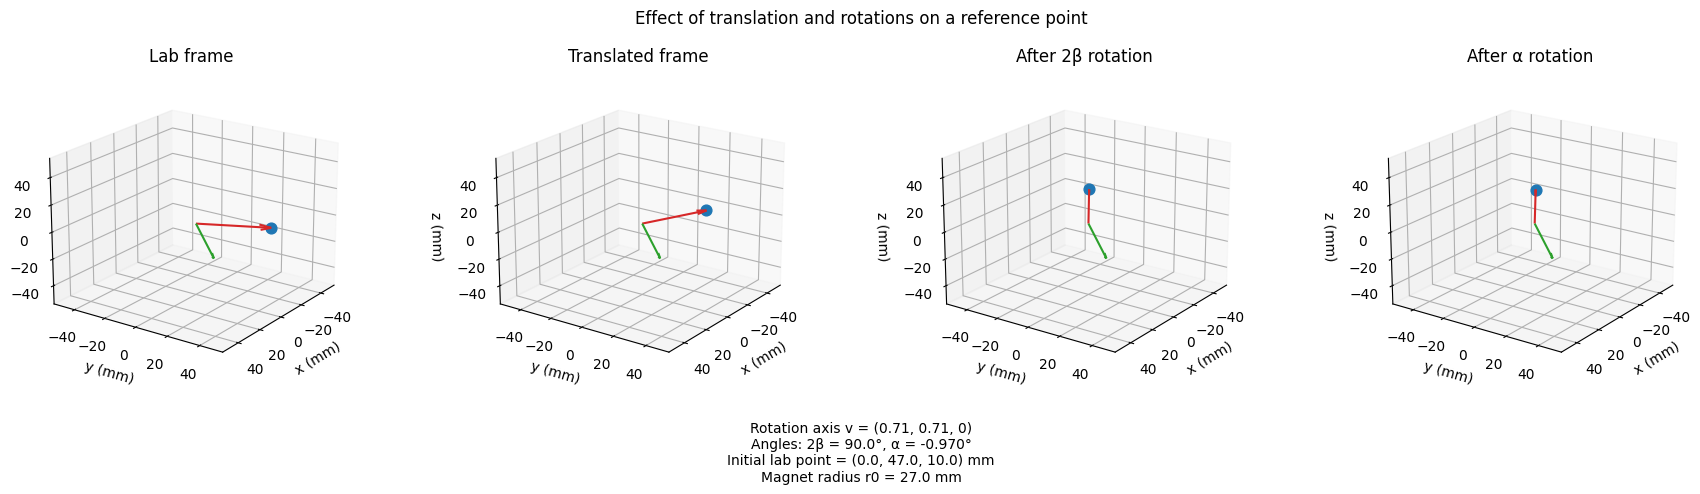

In [2]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 registers 3D projection

DEFAULT_DEMO_PARAMS = {
    "beta_deg": 45.0,
    "alpha_deg": -0.97,
    "r0_mm": 54.0 / 2.0,
    "z0_mm": 0.0,
    "lab_point": np.array([0.0, 54.0 / 2.0 + 20.0, 10.0], dtype=float),
}


def plot_transform_sequence(beta_deg=None, alpha_deg=None, lab_point=None, r0_mm=None, z0_mm=None):
    """Plot translation + rotation stages for a configurable reference point."""
    params = dict(DEFAULT_DEMO_PARAMS)
    if beta_deg is not None:
        params["beta_deg"] = beta_deg
    if alpha_deg is not None:
        params["alpha_deg"] = alpha_deg
    if lab_point is not None:
        params["lab_point"] = lab_point
    if r0_mm is not None:
        params["r0_mm"] = r0_mm
    if z0_mm is not None:
        params["z0_mm"] = z0_mm

    beta = np.deg2rad(params["beta_deg"])
    alpha = np.deg2rad(params["alpha_deg"])
    r0 = params["r0_mm"]
    z0 = params["z0_mm"]
    lab_point_arr = np.asarray(params["lab_point"], dtype=float)

    xp, yp, zp = translate_to_ring_frame(
        lab_point_arr[0], lab_point_arr[1], lab_point_arr[2], r0, z0, beta
    )
    xs, ys = rotate_xy_plane(xp, yp, 2 * beta)
    xt, yt, zt = rotate_about_v(xs, ys, zp, alpha, beta)

    axis_vec = np.array([np.cos(beta), np.sin(beta), 0.0])
    axis_label = f"Rotation axis v = ({axis_vec[0]:.2f}, {axis_vec[1]:.2f}, 0)"
    angle_label = (
        f"Angles: 2β = {np.rad2deg(2 * beta):.1f}°, α = {np.rad2deg(alpha):.3f}°"
    )
    initial_pos_label = (
        f"Initial lab point = ({lab_point_arr[0]:.1f}, {lab_point_arr[1]:.1f}, {lab_point_arr[2]:.1f}) mm"
    )
    radius_label = f"Magnet radius r0 = {r0:.1f} mm"

    stages = [
        ("Lab frame", lab_point_arr),
        ("Translated frame", np.array([xp, yp, zp], dtype=float)),
        ("After 2β rotation", np.array([xs, ys, zp], dtype=float)),
        ("After α rotation", np.array([xt, yt, zt], dtype=float)),
    ]
    coords_stack = np.vstack([coords for _, coords in stages])
    axis_limit = max(1.0, np.max(np.abs(coords_stack)) * 1.1)

    def _set_equal_cube(ax, limit):
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
        ax.set_zlim(-limit, limit)

    fig = plt.figure(figsize=(18, 4))
    for idx, (title, coords) in enumerate(stages, start=1):
        ax = fig.add_subplot(1, 4, idx, projection="3d")
        ax.scatter(*coords, color="tab:blue", s=60)
        ax.quiver(0, 0, 0, *coords, color="tab:red", arrow_length_ratio=0.15)
        ax.quiver(0, 0, 0, *(axis_vec * axis_limit), color="tab:green", arrow_length_ratio=0.1)
        ax.set_title(title)
        ax.set_xlabel("x (mm)")
        ax.set_ylabel("y (mm)")
        ax.set_zlabel("z (mm)")
        ax.view_init(elev=20, azim=35)
        _set_equal_cube(ax, axis_limit)

    fig.suptitle("Effect of translation and rotations on a reference point")
    fig.text(
        0.5,
        -0.05,
        f"{axis_label}\n{angle_label}\n{initial_pos_label}\n{radius_label}",
        ha="center",
        va="top",
    )
    fig.tight_layout()
    plt.show()


plot_transform_sequence()

In [3]:
import ipywidgets as widgets

mode_toggle = widgets.ToggleButtons(
    options=[("Use preset example", "preset"), ("Use custom controls", "custom")],
    value="preset",
    description="Mode:",
    button_style="",
    tooltips=["Lock parameters to the reference example", "Adjust every parameter manually"],
)

beta_slider = widgets.FloatSlider(
    description="β (deg)",
    min=-180.0,
    max=180.0,
    step=1.0,
    value=DEFAULT_DEMO_PARAMS["beta_deg"],
    continuous_update=False,
)
alpha_slider = widgets.FloatSlider(
    description="α (deg)",
    min=-15.0,
    max=15.0,
    step=0.1,
    value=DEFAULT_DEMO_PARAMS["alpha_deg"],
    continuous_update=False,
)
x_slider = widgets.FloatSlider(
    description="x₀ (mm)",
    min=-50.0,
    max=50.0,
    step=1.0,
    value=DEFAULT_DEMO_PARAMS["lab_point"][0],
    continuous_update=False,
)
y_slider = widgets.FloatSlider(
    description="y₀ (mm)",
    min=-50.0,
    max=150.0,
    step=1.0,
    value=DEFAULT_DEMO_PARAMS["lab_point"][1],
    continuous_update=False,
)
z_slider = widgets.FloatSlider(
    description="z₀ (mm)",
    min=-50.0,
    max=50.0,
    step=1.0,
    value=DEFAULT_DEMO_PARAMS["lab_point"][2],
    continuous_update=False,
)
r0_slider = widgets.FloatSlider(
    description="r₀ (mm)",
    min=10.0,
    max=60.0,
    step=1.0,
    value=DEFAULT_DEMO_PARAMS["r0_mm"],
    continuous_update=False,
)

slider_controls = [beta_slider, alpha_slider, x_slider, y_slider, z_slider, r0_slider]
slider_defaults = [
    DEFAULT_DEMO_PARAMS["beta_deg"],
    DEFAULT_DEMO_PARAMS["alpha_deg"],
    DEFAULT_DEMO_PARAMS["lab_point"][0],
    DEFAULT_DEMO_PARAMS["lab_point"][1],
    DEFAULT_DEMO_PARAMS["lab_point"][2],
    DEFAULT_DEMO_PARAMS["r0_mm"],
]


def _apply_defaults():
    for slider, value in zip(slider_controls, slider_defaults):
        with slider.hold_trait_notifications():
            slider.value = value


def _set_slider_state(mode_value):
    disabled = mode_value != "custom"
    for slider in slider_controls:
        slider.disabled = disabled
    if disabled:
        _apply_defaults()


def _on_mode_change(change):
    if change.get("name") == "value":
        _set_slider_state(change["new"])


_set_slider_state(mode_toggle.value)
mode_toggle.observe(_on_mode_change, names="value")


def _render_demo(mode, beta_deg, alpha_deg, x_mm, y_mm, z_mm, r0_mm):
    if mode == "preset":
        plot_transform_sequence()
    else:
        plot_transform_sequence(
            beta_deg=beta_deg,
            alpha_deg=alpha_deg,
            lab_point=np.array([x_mm, y_mm, z_mm], dtype=float),
            r0_mm=r0_mm,
        )


controls = widgets.VBox(
    [
        mode_toggle,
        widgets.HBox([beta_slider, alpha_slider]),
        widgets.HBox([x_slider, y_slider]),
        widgets.HBox([z_slider, r0_slider]),
    ]
)

interactive_out = widgets.interactive_output(
    _render_demo,
    {
        "mode": mode_toggle,
        "beta_deg": beta_slider,
        "alpha_deg": alpha_slider,
        "x_mm": x_slider,
        "y_mm": y_slider,
        "z_mm": z_slider,
        "r0_mm": r0_slider,
    },
)

display(widgets.VBox([controls, interactive_out]))

These are the functions that calculate the magnetic field created by a ZS configuration in Halbach configuration:

In [4]:
def brond(x, y, z):
    """Calculate the magnetic field components from a rectangular magnet at position (x, y, z)."""
    x, y, z = _broadcast(x, y, z)   # Ensure inputs are numpy arrays with float dtype
    r = np.sqrt(x**2 + y**2 + z**2) + EPS  # Norm with EPS to avoid division by zero
    # Compute field components
    bxx = 0.5 * np.log(np.clip(r - z, EPS, None) / np.clip(r + z, EPS, None))
    byy = -np.arctan(np.divide(y * r, x * z + EPS))
    bzz = 0.5 * np.log(np.clip(r - x, EPS, None) / np.clip(r + x, EPS, None))
    return np.stack((bxx, byy, bzz), axis=-1)


def bmagnet(x, y, z, a, b, c, Br):
    """Calculate the magnetic field from a rectangular magnet
    with dimensions (2a, 2b, 2c) and remanent field Br at position (x, y, z)."""
    term = (
        brond(x - a, y - b, z - c) - brond(x + a, y - b, z - c)
        + brond(x + a, y + b, z - c) - brond(x - a, y + b, z - c)
        + brond(x - a, y + b, z + c) - brond(x - a, y - b, z + c)
        + brond(x + a, y - b, z + c) - brond(x + a, y + b, z + c)
    )
    return (Br / (4 * np.pi)) * term


def bdisrot(x, y, z, a, b, c, Br, r0, z0, alpha, beta):
    """Calculate the magnetic field from a rotated and displaced rectangular magnet."""
    x, y, z, r0, z0, alpha = _broadcast(x, y, z, r0, z0, alpha)
    xp, yp, zp = translate_to_ring_frame(x, y, z, r0, z0, beta)
    xs, ys = rotate_xy_plane(xp, yp, 2 * beta)
    xt, yt, zt = rotate_about_v(xs, ys, zp, alpha, beta)
    bvec = bmagnet(xt, yt, zt, a, b, c, Br)
    bxt = bvec[..., 0]
    byt = bvec[..., 1]
    bzt = bvec[..., 2]
    bxs, bys, bzs = inverse_rotate_about_v(bxt, byt, bzt, alpha, beta)
    bx, by = rotate_xy_plane(bxs, bys, -2 * beta)
    return np.stack((bx, by, bzs), axis=-1)


def bhallbach8(x, y, z, a, b, c, Br, R0, z0, alpha):
    """Calculate the magnetic field from an 8-segment Halbach array."""
    total = None
    for beta in BETAS:
        btmp = bdisrot(x, y, z, a, b, c, Br, R0, z0, alpha, beta)
        if total is None:
            total = np.zeros_like(btmp)
        total += btmp
    return total


def by_component(x, y, z, a, b, c, Br, R0, z0, alpha):
    """Calculate the By component of the magnetic field from an 8-segment Halbach array."""
    return bhallbach8(x, y, z, a, b, c, Br, R0, z0, alpha)[..., 1]


def bid_profile(z, length, B0, BL):
    """Ideal B-field profile for a Zeeman slower."""
    z = np.asarray(z, dtype=float)
    inside = np.clip(1 - z / length, 0.0, None)
    mask = (z >= 0) & (z <= length)
    return (BL + (B0 - BL) * np.sqrt(inside)) * mask

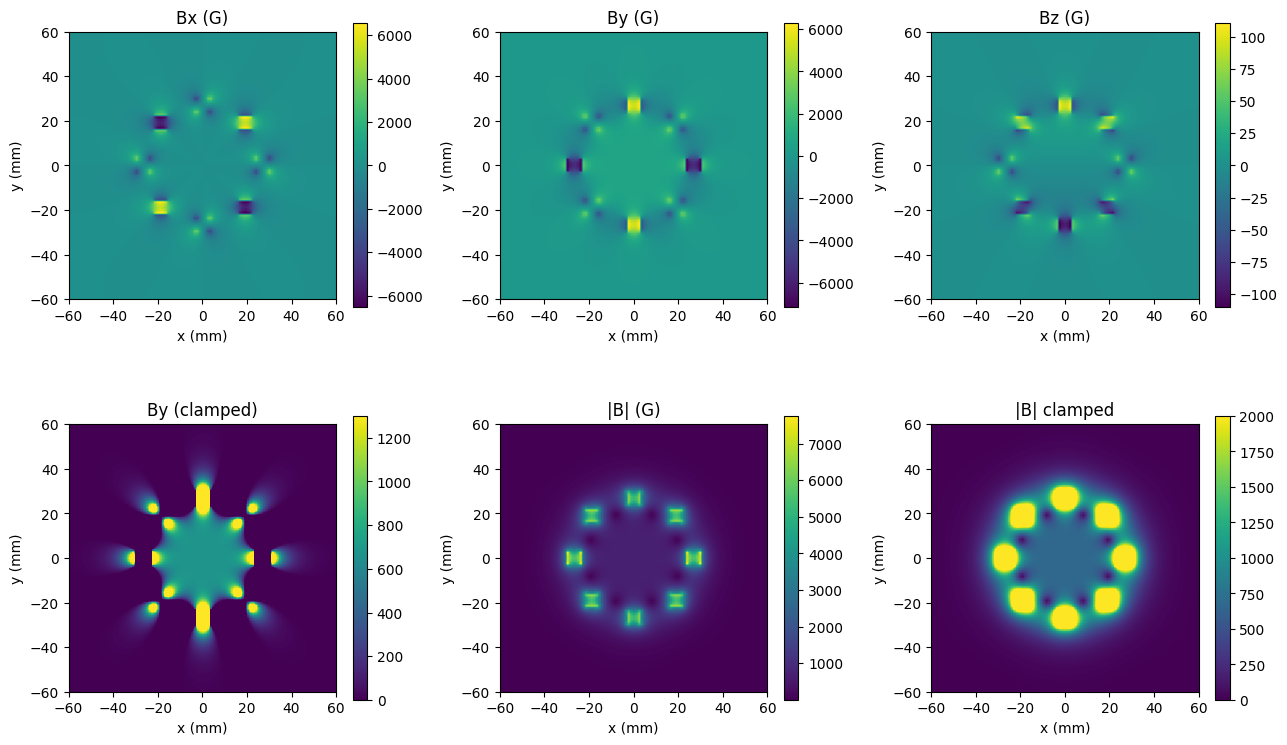

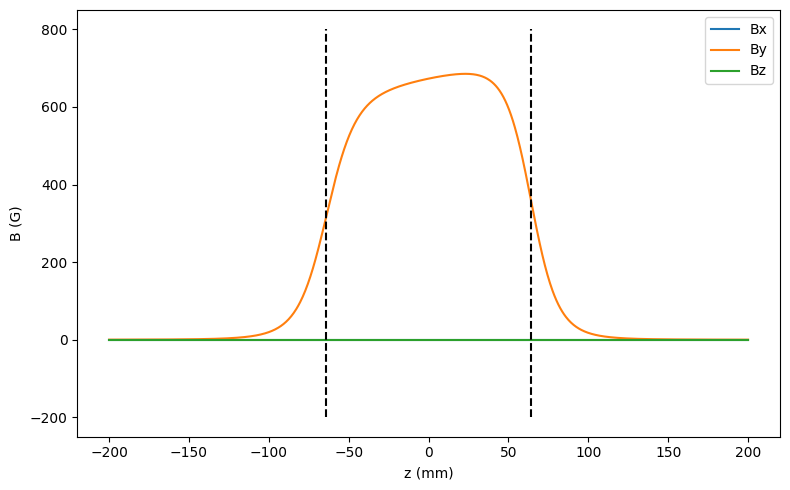

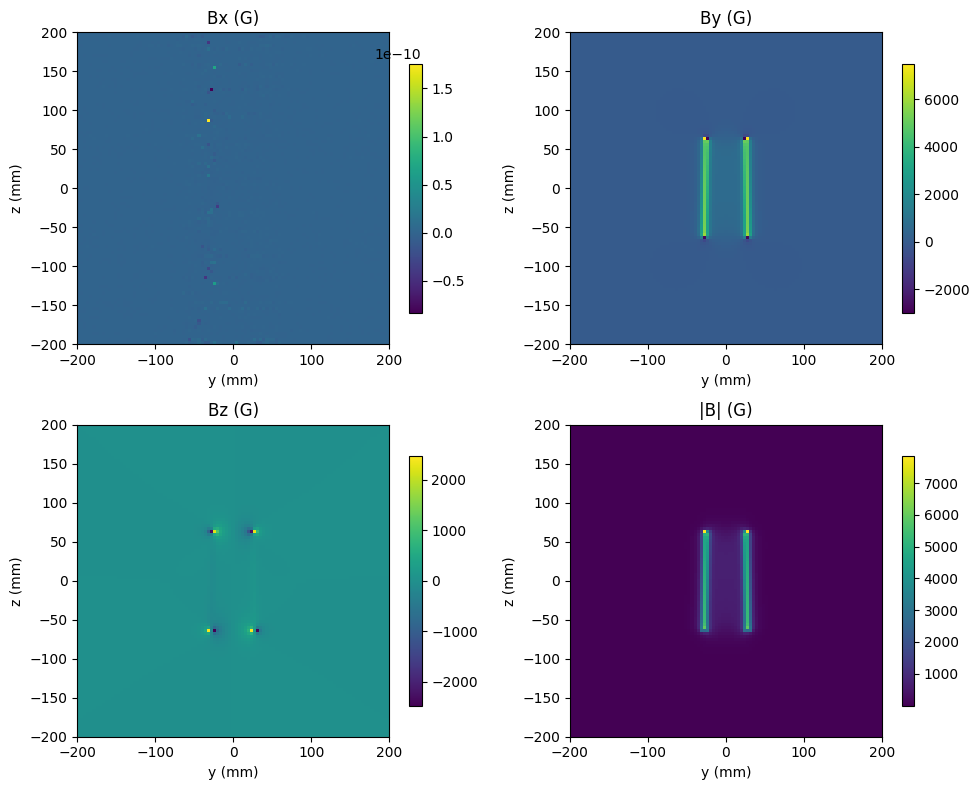

In [5]:
HALBACH_DEFAULTS = {
    "a_mm": 6.0 / 2.0,
    "b_mm": 6.0 / 2.0,
    "c_mm": 128.0 / 2.0,
    "Br": 1.08e4,
    "R0": 54.0 / 2.0,
    "z0": 0.0,
    "alpha_deg": -0.97,
}


def plot_halbach_maps(
    a_mm=HALBACH_DEFAULTS["a_mm"],
    b_mm=HALBACH_DEFAULTS["b_mm"],
    c_mm=HALBACH_DEFAULTS["c_mm"],
    Br=HALBACH_DEFAULTS["Br"],
    R0=HALBACH_DEFAULTS["R0"],
    z0=HALBACH_DEFAULTS["z0"],
    alpha_deg=HALBACH_DEFAULTS["alpha_deg"],
):
    """Visualize the Halbach array fields and fits for adjustable parameters."""
    alpha = np.deg2rad(alpha_deg)

    xgrid = np.linspace(-60.0, 60.0, 101)
    ygrid = np.linspace(-60.0, 60.0, 101)
    X, Y = np.meshgrid(xgrid, ygrid, indexing="xy")
    Bvec_xy = bhallbach8(X, Y, 0.0, a_mm, b_mm, c_mm, Br, R0, z0, alpha)
    Bmag_xy = np.linalg.norm(Bvec_xy, axis=-1)

    fig1, axes1 = plt.subplots(2, 3, figsize=(13, 8))
    plot_specs = [
        ("Bx (G)", Bvec_xy[..., 0], None),
        ("By (G)", Bvec_xy[..., 1], None),
        ("Bz (G)", Bvec_xy[..., 2], None),
        ("By (clamped)", Bvec_xy[..., 1], (0, 1300)),
        ("|B| (G)", Bmag_xy, None),
        ("|B| clamped", Bmag_xy, (0, 2000)),
    ]
    axes_flat = axes1.flatten()
    for ax, (title, data, clim) in zip(axes_flat, plot_specs):
        im = ax.imshow(
            data,
            origin="lower",
            extent=(xgrid[0], xgrid[-1], ygrid[0], ygrid[-1]),
            cmap="viridis",
        )
        if clim:
            im.set_clim(*clim)
        ax.set_title(title)
        ax.set_xlabel("x (mm)")
        ax.set_ylabel("y (mm)")
        fig1.colorbar(im, ax=ax, shrink=0.8)
    fig1.tight_layout()

    zline = np.linspace(-200.0, 200.0, 1001)
    Bvec_line = bhallbach8(0.0, 0.0, zline, a_mm, b_mm, c_mm, Br, R0, z0, alpha)
    plt.figure(figsize=(8, 5))
    plt.plot(zline, Bvec_line[..., 0], label="Bx")
    plt.plot(zline, Bvec_line[..., 1], label="By")
    plt.plot(zline, Bvec_line[..., 2], label="Bz")
    plt.vlines([-c_mm, c_mm], ymin=-200, ymax=800, colors="k", linestyles="--")
    plt.xlabel("z (mm)")
    plt.ylabel("B (G)")
    plt.legend()
    plt.tight_layout()

    yspan = np.linspace(-200.0, 200.0, 101)
    zspan = np.linspace(-200.0, 200.0, 101)
    Yspan = yspan[np.newaxis, :]
    Zspan = zspan[:, np.newaxis]
    Bvec_yz = bhallbach8(0.0, Yspan, Zspan, a_mm, b_mm, c_mm, Br, R0, z0, alpha)
    fig3, axes3 = plt.subplots(2, 2, figsize=(10, 8))
    for idx, title in enumerate(["Bx", "By", "Bz", "|B|"]):
        data = Bvec_yz[..., idx] if idx < 3 else np.linalg.norm(Bvec_yz, axis=-1)
        ax = axes3.flat[idx]
        im = ax.imshow(
            data,
            origin="lower",
            extent=(yspan[0], yspan[-1], zspan[0], zspan[-1]),
            cmap="viridis",
        )
        ax.set_title(f"{title} (G)")
        ax.set_xlabel("y (mm)")
        ax.set_ylabel("z (mm)")
        fig3.colorbar(im, ax=ax, shrink=0.8)
    fig3.tight_layout()
plot_halbach_maps()

In [6]:
import ipywidgets as widgets

half_dim_options = [
    ("3.0 mm (6 mm block)", 3.0),
    ("4.0 mm (8 mm block)", 4.0),
    ("5.0 mm (10 mm block)", 5.0),
]
length_options = [
    ("50.0 mm (100 mm)", 50.0),
    ("64.0 mm (128 mm)", 64.0),
    ("80.0 mm (160 mm)", 80.0),
]
remanence_options = [
    ("9.5 kG", 9.5e3),
    ("10.8 kG", 1.08e4),
    ("12.0 kG", 1.2e4),
]
radius_options = [
    ("22 mm", 22.0),
    ("27 mm", 27.0),
    ("35 mm", 35.0),
]
z0_options = [("-10 mm", -10.0), ("0 mm", 0.0), ("+10 mm", 10.0)]
alpha_options = [
    ("-5°", -5.0),
    ("-2°", -2.0),
    ("-0.97°", -0.97),
    ("0°", 0.0),
]

a_toggle = widgets.ToggleButtons(
    options=half_dim_options,
    value=HALBACH_DEFAULTS["a_mm"],
    description="a",
    tooltips=["Half-width a" for _ in half_dim_options],
)
b_toggle = widgets.ToggleButtons(
    options=half_dim_options,
    value=HALBACH_DEFAULTS["b_mm"],
    description="b",
    tooltips=["Half-height b" for _ in half_dim_options],
)
c_toggle = widgets.ToggleButtons(
    options=length_options,
    value=HALBACH_DEFAULTS["c_mm"],
    description="c",
    tooltips=["Half-length c" for _ in length_options],
)
Br_toggle = widgets.ToggleButtons(
    options=remanence_options,
    value=HALBACH_DEFAULTS["Br"],
    description="Br",
)
R0_toggle = widgets.ToggleButtons(
    options=radius_options,
    value=HALBACH_DEFAULTS["R0"],
    description="R₀",
)
z0_toggle = widgets.ToggleButtons(
    options=z0_options,
    value=HALBACH_DEFAULTS["z0"],
    description="z₀",
)
alpha_toggle = widgets.ToggleButtons(
    options=alpha_options,
    value=HALBACH_DEFAULTS["alpha_deg"],
    description="α",
)

controls = widgets.VBox(
    [
        widgets.HTML("<b>Halbach parameter toggles</b>"),
        widgets.HBox([a_toggle, b_toggle, c_toggle]),
        widgets.HBox([Br_toggle, R0_toggle, alpha_toggle, z0_toggle]),
    ]
)

interactive_fields = widgets.interactive_output(
    plot_halbach_maps,
    {
        "a_mm": a_toggle,
        "b_mm": b_toggle,
        "c_mm": c_toggle,
        "Br": Br_toggle,
        "R0": R0_toggle,
        "z0": z0_toggle,
        "alpha_deg": alpha_toggle,
    },
)

display(widgets.VBox([controls, interactive_fields]))

Velocity from 1000 to 50 m/s
B-field from 250.0 to 1854.2 G
Detuning -2.714 GHz
Length 26.0 cm (eta=0.75)


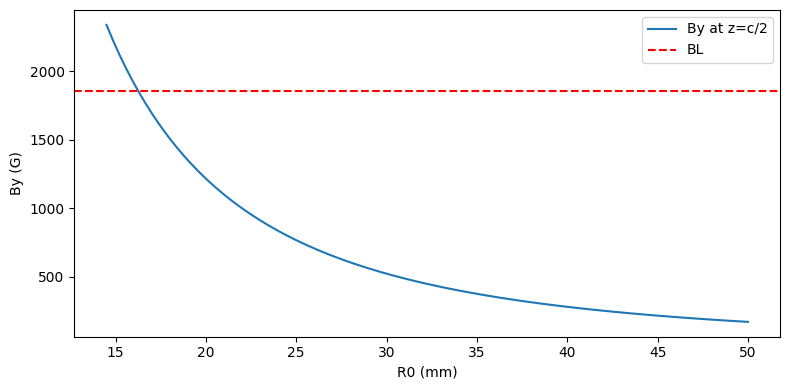

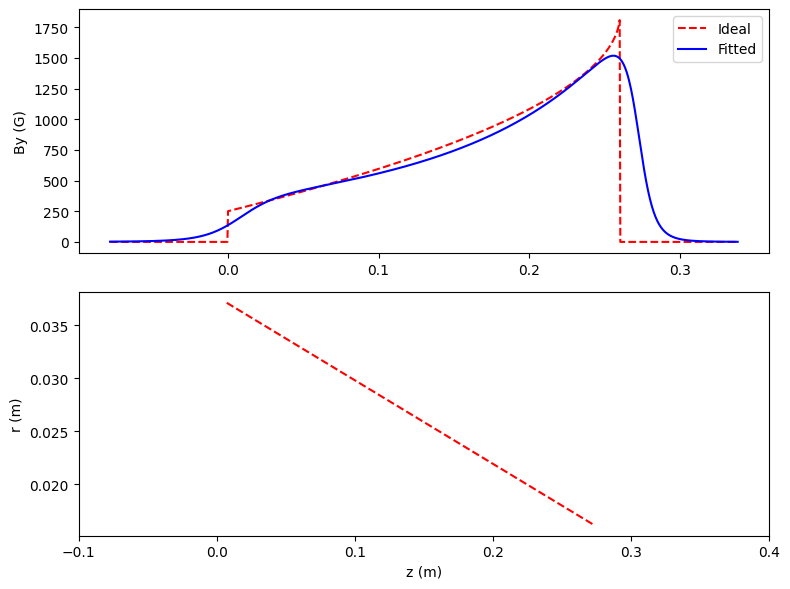

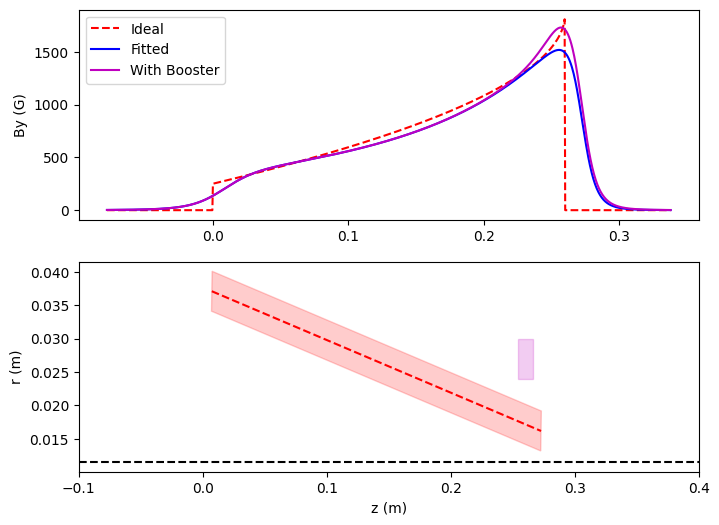

In [7]:
PHYSICAL_CONSTANTS = {
    "gamma": 1 / 4.6e-9,
    "kL": 2 * np.pi / 423e-9,
    "M": 40 * 1.66e-27,
    "h": 6.626e-34,
    "muB": 6.626e-34 * 1.4e6,
    "gJp": 1.0,
}
PHYSICAL_CONSTANTS["hbar"] = PHYSICAL_CONSTANTS["h"] / (2 * np.pi)

ZS_DESIGN_DEFAULTS = {
    "v0": 1000.0,
    "vL": 50.0,
    "B0": 250.0,
    "eta": 0.75,
}


def plot_zeeman_design(v0=None, vL=None, B0=None, eta=None):
    """Show Zeeman slower design curves for adjustable capture/release fields."""
    params = dict(ZS_DESIGN_DEFAULTS)
    if v0 is not None:
        params["v0"] = v0
    if vL is not None:
        params["vL"] = vL
    if B0 is not None:
        params["B0"] = B0
    if eta is not None:
        params["eta"] = eta

    if params["v0"] <= params["vL"]:
        raise ValueError("Initial velocity v0 must exceed final velocity vL.")
    if not (0 < params["eta"] <= 1):
        raise ValueError("Efficiency eta must lie in (0, 1].")

    const = PHYSICAL_CONSTANTS
    gamma = const["gamma"]
    kL = const["kL"]
    M = const["M"]
    hbar = const["hbar"]
    muB = const["muB"]
    gJp = const["gJp"]

    v0 = params["v0"]
    vL = params["vL"]
    B0 = params["B0"]
    eta = params["eta"]

    delta_B = hbar * kL * (v0 - vL) / (gJp * muB)
    BL = B0 + delta_B
    L = M * v0**2 / (hbar * kL * gamma * eta)
    delta_L = -kL * (v0 + vL) / 2 - gJp * muB / hbar * (BL + B0) / 2

    print(f"Velocity from {v0:.0f} to {vL:.0f} m/s")
    print(f"B-field from {B0:.1f} to {BL:.1f} G")
    print(f"Detuning {delta_L / (2 * np.pi * 1e9):.3f} GHz")
    print(f"Length {L * 100:.1f} cm (eta={eta:.2f})")

    a_mm = HALBACH_DEFAULTS["a_mm"]
    b_mm = HALBACH_DEFAULTS["b_mm"]
    c_mm = HALBACH_DEFAULTS["c_mm"]
    Br = HALBACH_DEFAULTS["Br"]

    R0s = np.linspace(19.0 / 2 + 2 + a_mm, 50.0, 101)
    Bmid = by_component(0.0, 0.0, c_mm / 2, a_mm, b_mm, c_mm, Br, R0s, 0.0, 0.0)
    plt.figure(figsize=(8, 4))
    plt.plot(R0s, Bmid, label="By at z=c/2")
    plt.axhline(BL, color="r", linestyle="--", label="BL")
    plt.xlabel("R0 (mm)")
    plt.ylabel("By (G)")
    plt.legend()
    plt.tight_layout()

    zgrid = L * np.linspace(-0.3, 1.3, 1001)
    a_si = a_mm * 1e-3
    b_si = b_mm * 1e-3
    c_si = c_mm * 1e-3

    def residuals(p):
        return bid_profile(zgrid, 1.05 * L, B0, BL) - by_component(
            0.0, 0.0, zgrid, a_si, b_si, p[0], Br, p[1], p[2], p[3]
        )

    par0 = np.array([L / 2.0, 0.028, L / 2.0, -5 * np.pi / 180.0])
    parfit = least_squares(residuals, par0).x

    plt.figure(figsize=(8, 6))
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(zgrid, bid_profile(zgrid, L, B0, BL), "r--", label="Ideal")
    ax1.plot(
        zgrid,
        by_component(0.0, 0.0, zgrid, a_si, b_si, parfit[0], Br, parfit[1], parfit[2], parfit[3]),
        "b-",
        label="Fitted",
    )
    ax1.set_ylabel("By (G)")
    ax1.legend()
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(
        parfit[2] + parfit[0] * np.array([-1, 1]),
        parfit[1] + np.sin(parfit[3]) * parfit[0] * np.array([-1, 1]),
        "r--",
    )
    ax2.set_xlim(-0.1, 0.4)
    ax2.set_xlabel("z (m)")
    ax2.set_ylabel("r (m)")
    plt.tight_layout()

    R2 = 27e-3
    c2 = 6e-3
    z2 = L
    alpha2 = -5 * np.pi / 180.0

    plt.figure(figsize=(8, 6))
    ax1 = plt.subplot(2, 1, 1)
    base_by = by_component(0.0, 0.0, zgrid, a_si, b_si, parfit[0], Br, parfit[1], parfit[2], parfit[3])
    aux_by = by_component(0.0, 0.0, zgrid, a_si, b_si, c2, Br, R2, z2, alpha2)
    ax1.plot(zgrid, bid_profile(zgrid, L, B0, BL), "r--", label="Ideal")
    ax1.plot(zgrid, base_by, "b-", label="Fitted")
    ax1.plot(zgrid, base_by + aux_by, "m-", label="With Booster")
    ax1.legend()
    ax1.set_ylabel("By (G)")
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot([-0.1, 0.4], 1e-3 * (19 / 2 + 2) * np.ones(2), "k--")
    ax2.plot(
        parfit[2] + parfit[0] * np.array([-1, 1]),
        parfit[1] + np.sin(parfit[3]) * parfit[0] * np.array([-1, 1]),
        "r--",
    )
    core_x = parfit[2] + parfit[0] * np.array([-1, 1, 1, -1]) + a_si * np.sin(parfit[3]) * np.array([1, 1, -1, -1])
    core_y = parfit[1] + np.sin(parfit[3]) * parfit[0] * np.array([-1, 1, 1, -1]) + a_si * np.cos(parfit[3]) * np.array([-1, -1, 1, 1])
    ax2.fill(core_x, core_y, color="r", alpha=0.2)
    booster_x = z2 + c2 * np.array([-1, 1, 1, -1])
    booster_y = R2 + a_si * np.array([-1, -1, 1, 1])
    ax2.fill(booster_x, booster_y, color="m", alpha=0.2)
    ax2.set_xlim(-0.1, 0.4)
    ax2.set_xlabel("z (m)")
    ax2.set_ylabel("r (m)")


plot_zeeman_design()

In [8]:
design_controls = widgets.VBox(
    [
        widgets.HTML("<b>Zeeman slower design sliders</b>"),
        widgets.HBox(
            [
                widgets.FloatSlider(
                    value=ZS_DESIGN_DEFAULTS["v0"],
                    min=200.0,
                    max=1500.0,
                    step=10.0,
                    description="v₀ (m/s)",
                    continuous_update=False,
                ),
                widgets.FloatSlider(
                    value=ZS_DESIGN_DEFAULTS["vL"],
                    min=10.0,
                    max=400.0,
                    step=5.0,
                    description="vᴸ (m/s)",
                    continuous_update=False,
                ),
            ]
        ),
        widgets.HBox(
            [
                widgets.FloatSlider(
                    value=ZS_DESIGN_DEFAULTS["B0"],
                    min=50.0,
                    max=500.0,
                    step=5.0,
                    description="B₀ (G)",
                    continuous_update=False,
                ),
                widgets.FloatSlider(
                    value=ZS_DESIGN_DEFAULTS["eta"],
                    min=0.3,
                    max=0.95,
                    step=0.01,
                    description="η",
                    readout_format=".2f",
                    continuous_update=False,
                ),
            ]
        ),
    ]
)

v0_slider, vL_slider = design_controls.children[1].children
B0_slider, eta_slider = design_controls.children[2].children

design_output = widgets.interactive_output(
    plot_zeeman_design,
    {
        "v0": v0_slider,
        "vL": vL_slider,
        "B0": B0_slider,
        "eta": eta_slider,
    },
)

display(widgets.VBox([design_controls, design_output]))